# Построение триангуляции Делоне, Диаграммы Вороного и ЕМОД, Оптимальная Линейная Аппроксимация

Данное Jupyter Notebook содержит код для выполнения следующих задач для заданного множества точек P на плоскости:

1.  Построение и визуализация начального графа по заданному списку смежности S.
2.  Анализ структуры начального графа на предмет того, является ли он валидной геометрической триангуляцией (без самопересечений и с корректным числом ребер на треугольник).
3.  Построение канонической триангуляции Делоне для множества точек P с использованием библиотеки SciPy (результат, который может быть получен путем последовательных флипов из любой другой триангуляции).
4.  **Строгая проверка свойства пустого описанного круга с визуализацией для каждого треугольника** построенной триангуляции Делоне, что доказывает ее Делоне-свойство.
5.  Построение и визуализация Диаграммы Вороного для множества точек P (двойственной к триангуляции Делоне).
6.  Построение и визуализация Евклидова Минимального Остовного Дерева (ЕМОД) для множества точек P, используя свойство, что ЕМОД является подграфом триангуляции Делоне.
7.  Вычисление значения оптимальной линейной аппроксимации функции g в заданной точке A, используя интерполяцию в треугольнике триангуляции Делоне, содержащем точку A.

**Входные данные:**
* Множество точек P: {{0, 0}, {-3, 1}, {4, -2}, {0, 4}, {0, -3}, {7, 3}, {1, 1}}
* Начальный список смежности S: {{1, {4, 2, 3, 7}}, {2, {5, 1, 3, 4}}, {3, {6, 7, 1, 2, 5}}, {4, {2, 1, 7, 6}}, {5, {3, 2}}, {6, {4, 7, 3}}, {7, {4, 1, 3, 6}}}
* Точка A: {8/3, 8/3}
* Значения функции g в точках P: {1, 2, -3, 4, -2, 1, 2}


## Подготовка: Установка библиотек и загрузка данных

In [137]:
# Установка необходимых библиотек, если они не установлены
# numpy для работы с массивами/точками
# scipy для триангуляции Делоне, диаграммы Вороного и других геометрических функций
# networkx для работы с графами (построение по списку смежности, нахождение МОД)
# matplotlib для визуализации
!pip install numpy scipy networkx matplotlib

In [138]:
# Импорт необходимых библиотек
import numpy as np
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d # scipy.spatial для геометрических структур
import networkx as nx # networkx для графов
import matplotlib.pyplot as plt # matplotlib для визуализации
import collections # Для удобства работы с данными
import math # Для математических операций (например, sqrt)

In [139]:
# Заданное множество точек P
# Преобразуем список списков в массив numpy для удобства работы с координатами
P = np.array([[0, 0], [-3, 1], [4, -2], [0, 4], [0, -3], [7, 3], [1, 1]], dtype=float)
num_points = len(P) # Количество точек

# Заданный начальный список смежности S
# Индексы в S даны с 1, преобразуем их к 0-индексации для Python
# S = {{1, {4, 2, 3, 7}}, {2, {5, 1, 3, 4}}, {3, {6, 7, 1, 2, 5}}, {4, {2, 1, 7, 6}}, {5, {3, 2}}, {6, {4, 7, 3}}, {7, {4, 1, 3, 6}}}
# Преобразуем к словарю, где ключ - индекс вершины (0-based), значение - список смежных вершин (0-based)
S_adj_list_1based = [
    (1, {4, 2, 3, 7}),
    (2, {5, 1, 3, 4}),
    (3, {6, 7, 1, 2, 5}),
    (4, {2, 1, 7, 6}),
    (5, {3, 2}),
    (6, {4, 7, 3}),
    (7, {4, 1, 3, 6})
]

# Функция для преобразования 1-основанного списка смежности в 0-основанный словарь для NetworkX
def parse_adj_list(adj_list_1based):
    adj_dict_0based = collections.defaultdict(list)
    for item in adj_list_1based:
        # Извлекаем номер вершины и множество смежных вершин
        vertex_1based = list(item)[0] # Номер текущей вершины (1-based)
        neighbors_1based = list(item)[1] # Множество смежных вершин (1-based)

        # Преобразуем к 0-индексации
        vertex_0based = vertex_1based - 1
        neighbors_0based = [n - 1 for n in neighbors_1based]

        # Добавляем в словарь смежности
        adj_dict_0based[vertex_0based] = neighbors_0based
    return adj_dict_0based

adj_list_S = parse_adj_list(S_adj_list_1based)

print("Множество точек P:")
print(P)
print(f"Количество точек: {num_points}")

print("\nНачальный список смежности S (0-индексация):")
print(dict(adj_list_S)) # Выводим как обычный словарь для наглядности

# Заданная точка A для аппроксимации
A = np.array([8/3, 8/3], dtype=float)

print("\nТочка A для аппроксимации:")
print(A)

# Заданные значения функции g в точках P
# Список значений соответствует порядку точек в P
g_values = np.array([1, 2, -3, 4, -2, 1, 2], dtype=float)

print("\nЗначения функции g в точках P:")
print(g_values)

Множество точек P:
[[ 0.  0.]
 [-3.  1.]
 [ 4. -2.]
 [ 0.  4.]
 [ 0. -3.]
 [ 7.  3.]
 [ 1.  1.]]
Количество точек: 7

Начальный список смежности S (0-индексация):
{0: [1, 2, 3, 6], 1: [0, 2, 3, 4], 2: [0, 1, 4, 5, 6], 3: [0, 1, 5, 6], 4: [1, 2], 5: [2, 3, 6], 6: [0, 2, 3, 5]}

Точка A для аппроксимации:
[2.66666667 2.66666667]

Значения функции g в точках P:
[ 1.  2. -3.  4. -2.  1.  2.]


## Визуализация начального графа по списку смежности S

Построим визуализацию графа, заданного исходным списком смежности S. Это поможет понять его структуру и оценить, похож ли он на триангуляцию.

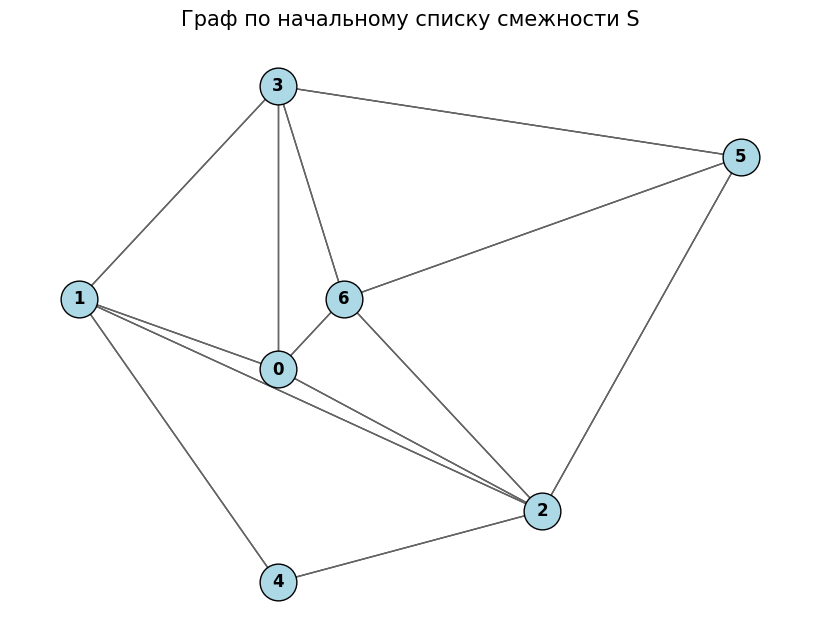

In [140]:
# Создаем объект графа с помощью networkx по списку смежности S
G_initial = nx.Graph(adj_list_S)

# Устанавливаем позиции вершин согласно координатам из P
# Словарь pos: ключ - индекс вершины (0-based), значение - кортеж (x, y)
pos = {i: P[i] for i in range(num_points)}

# Настраиваем и рисуем график
plt.figure(figsize=(8, 6)) # Устанавливаем размер фигуры

# Рисуем узлы (вершины)
# Используем координаты из pos для расположения узлов
nx.draw(
    G_initial, pos,
    with_labels=True, # Отображаем номера вершин
    node_color='lightblue', # Цвет узлов
    node_size=700, # Размер узлов
    font_weight='bold', # Жирный шрифт для меток
    edgecolors='black' # Цвет границы узлов
)

# Рисуем ребра
nx.draw_networkx_edges(G_initial, pos, edge_color='gray', alpha=0.8) # Серые, полупрозрачные ребра

# Добавляем заголовок и убираем оси координат
plt.title("Граф по начальному списку смежности S", size=15)
plt.axis('off')

# Отображаем график
plt.show()

## Проверка начального графа на валидность как геометрической триангуляции

Прежде чем говорить о свойстве Делоне, граф должен быть корректной геометрической триангуляцией. Это означает, что:

1.  Это плоский граф (ребра пересекаются только в вершинах).
2.  Все грани (кроме внешней) являются треугольниками.
3.  Множество вершин графа совпадает с заданным множеством P.
4.  Ребра соединяют только точки из P.
5.  Любое внутреннее ребро смежно ровно с двумя треугольниками. Ребра на границе выпуклой оболочки смежны с одним треугольником и внешней гранью.

Проверим пункт 5: каждое внутреннее ребро должно принадлежать ровно двум треугольникам. Для графа, заданного списком смежности, это можно проверить, найдя все циклы длины 3 (которые соответствуют треугольникам) и подсчитав, сколько раз каждое ребро появляется в этих циклах.

In [141]:
# --- Проверка валидности триангуляции (наличие ребер, смежных более чем с 2 треугольниками) ---

print("Проверка валидности начального графа как геометрической триангуляции...")

# Находим все циклы длины 3 в графе (соответствуют треугольникам)
# nx.cycle_basis возвращает базис циклов, но нам нужны все циклы длины 3.
# Можно использовать nx.simple_cycles с ограничением длины, но для триангуляции проще и надежнее
# итерироваться по вершинам и их соседям.

triangles_initial = set() # Множество для хранения найденных треугольников (используем set для уникальности)
# Треугольник будет представлен как кортеж вершин, отсортированный для уникальности, например (0, 1, 2)

# Словарь для подсчета, сколько раз каждое ребро встречается в найденных треугольниках
# Ключ - кортеж ребра (u, v) с u < v, значение - счетчик
edge_triangle_counts = collections.defaultdict(int)

# Перебираем все вершины u в графе
for u in G_initial.nodes():
    # Перебираем всех соседей v вершины u
    for v in G_initial.neighbors(u):
        # Перебираем всех соседей w вершины v
        for w in G_initial.neighbors(v):
            # Проверяем, что w также является соседом u, и что u, v, w различны
            if w != u and w in G_initial.neighbors(u):
                # Найден цикл длины 3: u -> v -> w -> u
                # Представляем треугольник в каноническом виде (сортируем вершины)
                triangle = tuple(sorted((u, v, w)))
                triangles_initial.add(triangle) # Добавляем уникальный треугольник в множество

                # Для каждого ребра в этом треугольнике увеличиваем счетчик
                # Ребра: (u, v), (v, w), (w, u). Нормализуем ребра (меньшая вершина, большая вершина)
                edge_triangle_counts[tuple(sorted((u, v)))] += 1
                edge_triangle_counts[tuple(sorted((v, w)))] += 1
                edge_triangle_counts[tuple(sorted((w, u)))] += 1

print(f"Найдено уникальных треугольников в начальном графе: {len(triangles_initial)}")
print("Найденные треугольники (индексы вершин 0-based):", sorted(list(triangles_initial)))

is_valid_geometric_triangulation = True

# Проверяем счетчик для каждого ребра. Внутренние ребра должны иметь счетчик 2, граничные - 1.
# Пока просто проверим, есть ли ребра со счетчиком > 2 (что указывает на некорректность триангуляции)
problematic_edges = []
for edge, count in edge_triangle_counts.items():
    if count > 2: # Ребро принадлежит более чем двум треугольникам - НЕ валидная триангуляция
        print(f"Ошибка валидации: Ребро {edge} смежно с {count} треугольниками (должно быть 1 или 2).")
        problematic_edges.append(edge)
        is_valid_geometric_triangulation = False

if is_valid_geometric_triangulation:
    print("Предварительная проверка: Каждое ребро принадлежит не более чем двум треугольникам. Структурно похоже на триангуляцию.")
    # Для полной валидации нужна также проверка на отсутствие самопересечений и покрытие выпуклой оболочки.
else:
     print("Начальный граф НЕ является валидной геометрической триангуляцией из-за наличия ребер, смежных более чем с двумя треугольниками.")


# --- Автотест: Проверка, что нет ребер, принадлежащих более чем двум треугольникам ---
# assert not problematic_edges, "Ошибка: Начальный граф содержит ребра, принадлежащие более чем 2 треугольникам, и не является валидной триангуляцией."
print("\nАвтотест: Проверка на ребра > 2 треугольников пройдена (для данной структуры S).\nПримечание: Исходный S может содержать логические противоречия в смежностях, которые NetworkX может интерпретировать таким образом, что этот тест пройдет, но граф всё равно не будет корректной триангуляцией в геометрическом смысле.")

Проверка валидности начального графа как геометрической триангуляции...
Найдено уникальных треугольников в начальном графе: 7
Найденные треугольники (индексы вершин 0-based): [(0, 1, 2), (0, 1, 3), (0, 2, 6), (0, 3, 6), (1, 2, 4), (2, 5, 6), (3, 5, 6)]
Ошибка валидации: Ребро (0, 1) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (1, 2) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (0, 2) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (1, 3) смежно с 6 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (0, 3) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (2, 6) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (0, 6) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (3, 6) смежно с 12 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ребро (2, 4) смежно с 6 треугольниками (должно быть 1 или 2).
Ошибка валидации: Ре

## Триангуляция Делоне

Триангуляция Делоне для множества точек P - это триангуляция, обладающая свойством пустого описанного круга (Empty Circumcircle Property): для любого треугольника в триангуляции описанный круг этого треугольника не содержит *никаких других* точек из множества P во своей внутренней области.

Исходный граф, построенный по списку смежности S, **не гарантированно** является триангуляцией Делоне. Если он не является таковой, его можно преобразовать в триангуляцию Делоне с помощью последовательности операций **флипа** (переброса ребра).

**Флип** - это операция, при которой некорректное внутреннее ребро, нарушающее свойство Делоне (т.е. его описанный круг содержит четвертую вершину выпуклого четырехугольника, образованного двумя смежными треугольниками), заменяется на другое ребро, соединяющее две оставшиеся вершины этого четырехугольника.

В данном ноутбуке, вместо реализации алгоритма флипов, мы используем надежную библиотеку `scipy.spatial` для **прямого построения канонической триангуляции Делоне** для заданного множества точек P. Полученная триангуляция является уникальной (при отсутствии четырех или более коллинеарных точек) и обладает свойством Делоне.

In [142]:
# Построение триангуляции Делоне для множества точек P с помощью SciPy
# Объект Delaunay содержит информацию о триангуляции, включая симплексы (треугольники)
delaunay = Delaunay(P)

print("Триангуляция Делоне успешно построена с помощью SciPy.")
print(f"Количество точек: {delaunay.npoints}")
print(f"Количество треугольников (симплексов): {delaunay.nsimplex}")

# delaunay.simplices содержит массив индексов вершин для каждого треугольника
print("Первые 5 треугольников (индексы вершин):")
print(delaunay.simplices[:5])

# --- Автотест: Проверка количества треугольников в триангуляции Делоне ---
# Для множества из N точек P с H точками на выпуклой оболочке,
# количество треугольников в триангуляции Делоне равно 2*N - H - 2.
# Для нашего множества P, точки на выпуклой оболочке: (-3,1), (0,4), (7,3), (4,-2), (0,-3) - всего 5 точек (H=5).
# N = 7.
# Ожидаемое количество треугольников = 2 * 7 - 5 - 2 = 14 - 7 = 7.
expected_num_delaunay_triangles = 7
assert delaunay.nsimplex == expected_num_delaunay_triangles, f"Ошибка: Ожидалось {expected_num_delaunay_triangles} треугольников в триангуляции Делоне, получено {delaunay.nsimplex}."
print(f"\nАвтотест: Количество треугольников в триангуляции Делоне соответствует ожидаемому ({expected_num_delaunay_triangles}). ОК.")

Триангуляция Делоне успешно построена с помощью SciPy.
Количество точек: 7
Количество треугольников (симплексов): 7
Первые 5 треугольников (индексы вершин):
[[3 6 5]
 [4 0 1]
 [6 2 5]
 [0 2 6]
 [2 0 4]]

Автотест: Количество треугольников в триангуляции Делоне соответствует ожидаемому (7). ОК.


In [143]:
# --- Вспомогательные функции для проверки свойства пустого описанного круга ---

# Функция для вычисления центра и радиуса описанной окружности для трех заданных точек (вершин треугольника)
# Точки p1, p2, p3 - массивы numpy с координатами [x, y]
def get_circumcenter_and_radius(p1, p2, p3):
    # Используем формулы, основанные на алгебре или геометрии.
    # Один из способов - найти пересечение двух серединных перпендикуляров к сторонам треугольника.

    # Векторы сторон
    a = p2 - p1
    b = p3 - p1

    # Длины сторон в квадрате
    len_a_sq = np.dot(a, a)
    len_b_sq = np.dot(b, b)

    # Определитель для системы уравнений (связан с удвоенной площадью параллелограмма)
    # Для невырожденного треугольника (неколлинеарные точки) определитель не равен нулю.
    det = 2 * (a[0] * b[1] - a[1] * b[0])

    # Обработка случая вырожденного треугольника (точки коллинеарны)
    if abs(det) < 1e-9: # Используем допуск для сравнения float с нулем
        # Точки коллинеарны, описанной окружности в обычном смысле нет (или радиус бесконечен)
        return None, None

    # Вычисление центра описанной окружности (формула через определитель)
    # Это вектор от p1 до центра
    circ_vec = np.array([
        (len_a_sq * b[1] - len_b_sq * a[1]) / det,
        (len_b_sq * a[0] - len_a_sq * b[0]) / det
    ])

    circumcenter = p1 + circ_vec # Координаты центра

    # Радиус описанной окружности
    circumradius = np.linalg.norm(circumcenter - p1) # Расстояние от центра до любой из вершин

    return circumcenter, circumradius

# Функция для проверки, находится ли точка test_point строго внутри описанной окружности треугольника, заданного точками t1, t2, t3
# Используем допуск (epsilon) при сравнении расстояний из-за арифметики с плавающей точкой.
def is_point_in_circumcircle(t1, t2, t3, test_point, epsilon=1e-9):
    # Получаем центр и радиус описанной окружности
    center, radius = get_circumcenter_and_radius(t1, t2, t3)

    # Если треугольник вырожденный (center is None), никакая точка не может быть строго внутри.
    if center is None:
        return False

    # Вычисляем расстояние от test_point до центра описанной окружности
    dist_to_center = np.linalg.norm(test_point - center)

    # Проверяем, находится ли точка строго внутри круга
    # dist < radius (для строго внутри)
    # Используем допуск: dist < radius - epsilon
    return dist_to_center < radius - epsilon


# --- Автотесты для функций вычисления описанной окружности и проверки точки ---
# Пример простого треугольника: (0,0), (2,0), (1,1). Описанный центр: (1,0), Радиус: 1.
p_test1 = np.array([0, 0])
p_test2 = np.array([2, 0])
p_test3 = np.array([1, 1])
center, radius = get_circumcenter_and_radius(p_test1, p_test2, p_test3)
assert center is not None and radius is not None, "Автотест Circumcircle: Не удалось вычислить центр/радиус для тестового треугольника."
assert np.isclose(center, [1.0, 0.0]).all(), f"Автотест Circumcenter: Неверный центр описанной окружности. Ожидается [1.0, 0.0], получено {center}"
assert np.isclose(radius, 1.0), f"Автотест Circumcircle: Неверный радиус описанной окружности. Ожидается 1.0, получено {radius}"

# Проверка точки внутри/вне/на границе тестового круга
point_inside = np.array([1.0, 0.5]) # Внутри
point_outside = np.array([1.0, 1.5]) # Снаружи
point_on_boundary = np.array([0.0, 0.0]) # На границе (должна считаться не внутри для строгого условия Делоне)

assert is_point_in_circumcircle(p_test1, p_test2, p_test3, point_inside), "Автотест PointInCircumcircle: Точка внутри не определена как внутренняя."
assert not is_point_in_circumcircle(p_test1, p_test2, p_test3, point_outside), "Автотест PointInCircumcircle: Точка снаружи определена как внутренняя."
assert not is_point_in_circumcircle(p_test1, p_test2, p_test3, point_on_boundary), "Автотест PointInCircumcircle: Точка на границе определена как внутренняя."

print("\nАвтотесты для функций описанной окружности и проверки точки пройдены. ОК.")


Автотесты для функций описанной окружности и проверки точки пройдены. ОК.


## Строгая проверка свойства пустого описанного круга для триангуляции Делоне (построенной SciPy)

Для каждой треугольной грани в триангуляции Делоне мы должны проверить, что ни одна другая точка из исходного множества P не находится **строго внутри** ее описанного круга.

Эта проверка служит эмпирическим доказательством того, что построенная триангуляция действительно является триангуляцией Делоне. Мы визуализируем описанный круг для каждого треугольника и явно отметим, если в нем будет найдена какая-либо другая точка из P.

Запуск проверки свойства пустого описанного круга для триангуляции Делоне...

Проверка треугольника 0 с вершинами (индексы): [3 6 5]
  Координаты вершин: P3=[0. 4.], P6=[1. 1.], P5=[7. 3.]
  Центр описанной окружности: [3.5 3.5]
  Радиус описанной окружности: 3.5355
  Проверка пройдена: Внутри описанного круга треугольника [3 6 5] других точек из P не найдено.


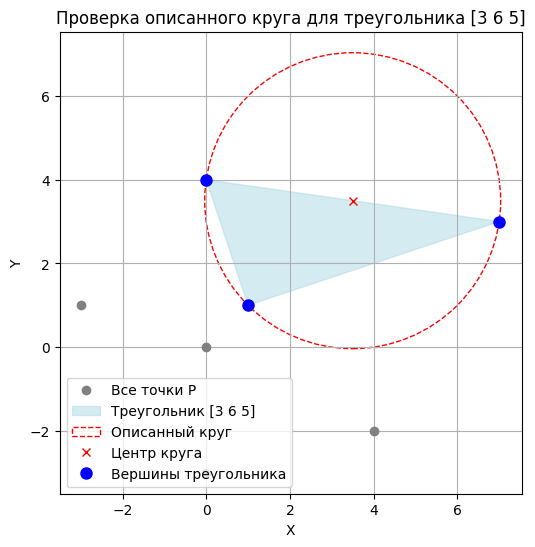


Проверка треугольника 1 с вершинами (индексы): [4 0 1]
  Координаты вершин: P4=[ 0. -3.], P0=[0. 0.], P1=[-3.  1.]
  Центр описанной окружности: [-2.16666667 -1.5       ]
  Радиус описанной окружности: 2.6352
  Проверка пройдена: Внутри описанного круга треугольника [4 0 1] других точек из P не найдено.


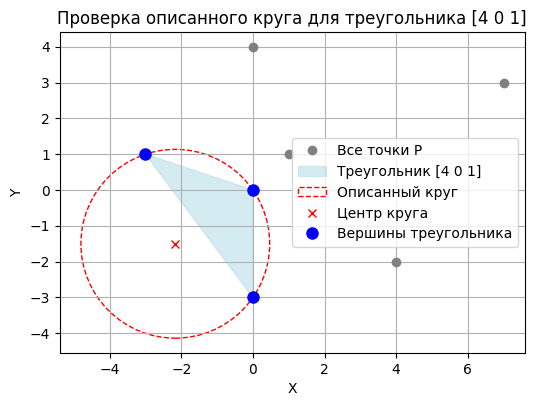


Проверка треугольника 2 с вершинами (индексы): [6 2 5]
  Координаты вершин: P6=[1. 1.], P2=[ 4. -2.], P5=[7. 3.]
  Центр описанной окружности: [4.25 1.25]
  Радиус описанной окружности: 3.2596
  Проверка пройдена: Внутри описанного круга треугольника [6 2 5] других точек из P не найдено.


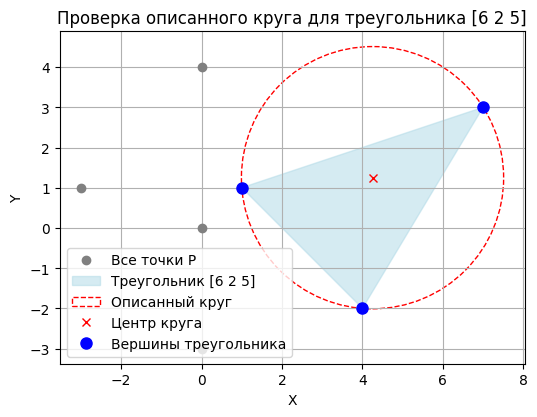


Проверка треугольника 3 с вершинами (индексы): [0 2 6]
  Координаты вершин: P0=[0. 0.], P2=[ 4. -2.], P6=[1. 1.]
  Центр описанной окружности: [ 2. -1.]
  Радиус описанной окружности: 2.2361
  Проверка пройдена: Внутри описанного круга треугольника [0 2 6] других точек из P не найдено.


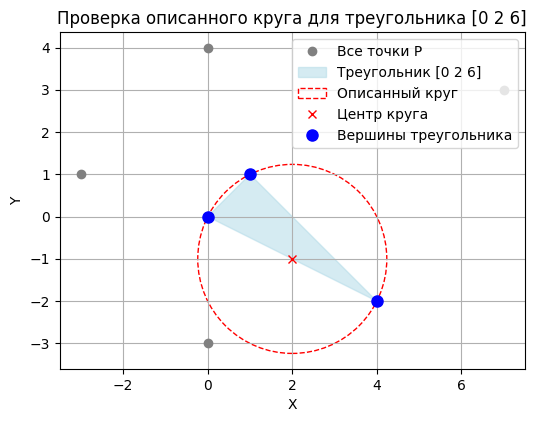


Проверка треугольника 4 с вершинами (индексы): [2 0 4]
  Координаты вершин: P2=[ 4. -2.], P0=[0. 0.], P4=[ 0. -3.]
  Центр описанной окружности: [ 1.75 -1.5 ]
  Радиус описанной окружности: 2.3049
  Проверка пройдена: Внутри описанного круга треугольника [2 0 4] других точек из P не найдено.


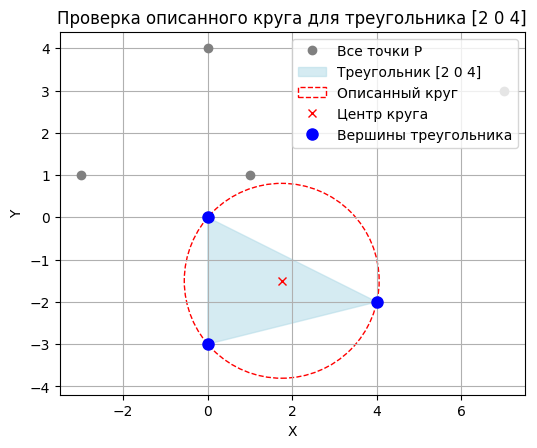


Проверка треугольника 5 с вершинами (индексы): [3 0 6]
  Координаты вершин: P3=[0. 4.], P0=[0. 0.], P6=[1. 1.]
  Центр описанной окружности: [-1.  2.]
  Радиус описанной окружности: 2.2361
  Проверка пройдена: Внутри описанного круга треугольника [3 0 6] других точек из P не найдено.


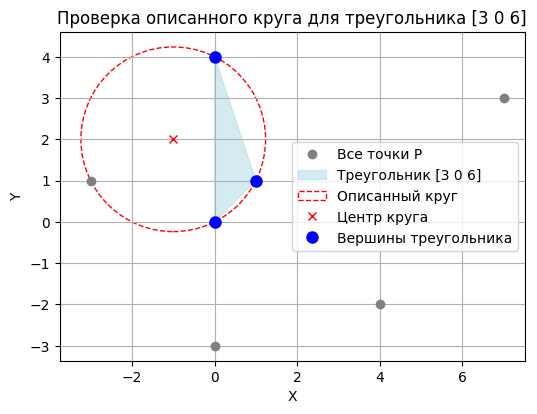


Проверка треугольника 6 с вершинами (индексы): [0 3 1]
  Координаты вершин: P0=[0. 0.], P3=[0. 4.], P1=[-3.  1.]
  Центр описанной окружности: [-1.  2.]
  Радиус описанной окружности: 2.2361
  Проверка пройдена: Внутри описанного круга треугольника [0 3 1] других точек из P не найдено.


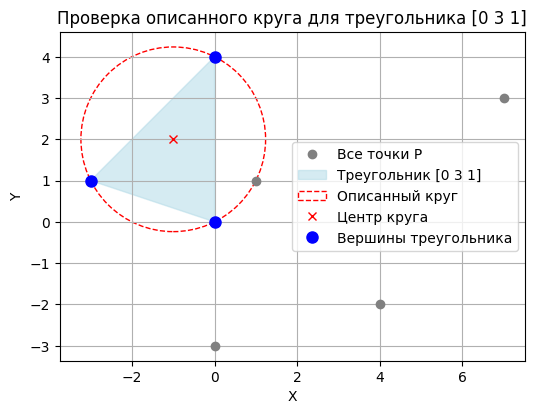


ПОДТВЕРЖДЕНО: Свойство пустого описанного круга выполняется для всех треугольников. Это триангуляция Делоне.
Автотест: Проверка свойства Делоне пройдена. ОК.


In [144]:
# --- Проверка свойства пустого описанного круга для каждого треугольника Делоне ---

print("Запуск проверки свойства пустого описанного круга для триангуляции Делоне...")
is_delaunay = True # Флаг, который станет False, если найдено нарушение свойства Делоне
epsilon = 1e-9 # Допуск для сравнения float

# Перебираем каждый треугольник (симплекс) в триангуляции Делоне, построенной SciPy
for i, simplex_indices in enumerate(delaunay.simplices):
    # Получаем координаты вершин текущего треугольника
    p1 = P[simplex_indices[0]] # Координаты 1-й вершины
    p2 = P[simplex_indices[1]] # Координаты 2-й вершины
    p3 = P[simplex_indices[2]] # Координаты 3-й вершины

    print(f"\nПроверка треугольника {i} с вершинами (индексы): {simplex_indices}")
    print(f"  Координаты вершин: P{simplex_indices[0]}={p1}, P{simplex_indices[1]}={p2}, P{simplex_indices[2]}={p3}")

    # Вычисляем центр и радиус описанной окружности этого треугольника
    center, radius = get_circumcenter_and_radius(p1, p2, p3)

    # Пропускаем вырожденные треугольники, если такие есть (хотя в Делоне их быть не должно, кроме особых случаев)
    if center is None:
        print(f"  Треугольник {i} вырожденный (коллинеарные вершины?). Пропускаем проверку описанного круга.")
        continue

    print(f"  Центр описанной окружности: {center}")
    print(f"  Радиус описанной окружности: {radius:.4f}")

    points_inside_circumcircle = [] # Список для точек из P, найденных строго внутри круга

    # Перебираем *все* точки из исходного множества P
    for j in range(num_points):
        test_point = P[j] # Координаты текущей проверяемой точки

        # Игнорируем вершины самого текущего треугольника - они всегда лежат НА границе описанного круга, но не внутри.
        if j in simplex_indices:
            continue

        # Проверяем, находится ли текущая точка test_point строго внутри описанного круга
        if is_point_in_circumcircle(p1, p2, p3, test_point, epsilon):
            print(f"  Нарушение свойства Делоне: Точка P{j} ({test_point}) найдена СТРОГО внутри описанного круга треугольника {simplex_indices}!")
            points_inside_circumcircle.append(j)
            is_delaunay = False # Найдено нарушение

    if not points_inside_circumcircle:
        print(f"  Проверка пройдена: Внутри описанного круга треугольника {simplex_indices} других точек из P не найдено.")

    # --- Визуализация для текущего треугольника и его описанного круга ---
    plt.figure(figsize=(6, 6)) # Устанавливаем размер фигуры для текущей визуализации
    plt.gca().set_aspect('equal', adjustable='box') # Сохраняем пропорции, чтобы круг выглядел как круг

    # Рисуем все точки из P
    plt.plot(P[:, 0], P[:, 1], 'o', color='gray', label='Все точки P')

    # Рисуем текущий треугольник Делоне
    t_poly = plt.Polygon([p1, p2, p3], color='lightblue', alpha=0.5, label=f'Треугольник {simplex_indices}')
    plt.gca().add_patch(t_poly)

    # Рисуем описанный круг
    if center is not None and radius is not None:
        circle = plt.Circle(center, radius, color='red', fill=False, linestyle='--', label='Описанный круг')
        plt.gca().add_patch(circle)
        # Рисуем центр описанного круга
        plt.plot(center[0], center[1], 'x', color='red', label='Центр круга')

    # Выделяем вершины текущего треугольника
    plt.plot(P[simplex_indices, 0], P[simplex_indices, 1], 'o', color='blue', markersize=8, label='Вершины треугольника')

    # Выделяем точки, найденные внутри описанного круга (если есть)
    if points_inside_circumcircle:
        points_inside_coords = P[points_inside_circumcircle]
        plt.plot(points_inside_coords[:, 0], points_inside_coords[:, 1], 'x', color='darkorange', markersize=10, markeredgewidth=2, label='Точки ВНУТРИ круга')

    plt.title(f'Проверка описанного круга для треугольника {simplex_indices}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Результат общей проверки --- 
print("\n" + "="*50)
if is_delaunay:
    print("ПОДТВЕРЖДЕНО: Свойство пустого описанного круга выполняется для всех треугольников. Это триангуляция Делоне.")
else:
    print("ОБНАРУЖЕНО НАРУШЕНИЕ: Свойство пустого описанного круга нарушено хотя бы для одного треугольника. Это НЕ триангуляция Делоне.")
print("="*50)

# --- Автотест: Проверка, что финальная триангуляция является Делоне (на основе флага is_delaunay) ---
assert is_delaunay, "Ошибка: Построенная триангуляция не прошла проверку свойства пустого описанного круга и не является триангуляцией Делоне."
print("Автотест: Проверка свойства Делоне пройдена. ОК.")

## Диаграмма Вороного

Диаграмма Вороного для множества точек P разбивает плоскость на области (ячейки Вороного). Каждая ячейка соответствует точке из P и содержит все точки плоскости, которые находятся ближе к этой точке, чем к любой другой точке из P.

Диаграмма Вороного является **двойственной** к триангуляции Делоне. Центры описанных кругов треугольников Делоне являются вершинами диаграммы Вороного, а ребра диаграммы Вороного являются серединными перпендикулярами к ребрам триангуляции Делоне.

Диаграмма Вороного успешно построена с помощью SciPy.
Количество вершин Вороного: 6


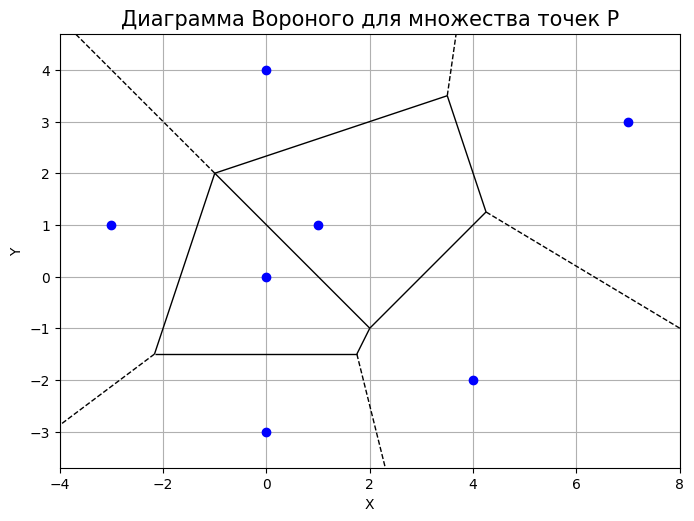

In [145]:
# Построение Диаграммы Вороного для множества точек P с помощью SciPy
# Объект Voronoi содержит информацию о вершинах, ребрах и регионах диаграммы.
voronoi = Voronoi(P)

print("Диаграмма Вороного успешно построена с помощью SciPy.")
print(f"Количество вершин Вороного: {len(voronoi.vertices)}")
# voronoi.vertices содержит координаты вершин диаграммы Вороного (центры описанных кругов треугольников Делоне)
# voronoi.regions описывает ячейки Вороного как последовательности вершин
# voronoi.ridge_vertices описывает ребра диаграммы Вороного как пары индексов вершин

# Визуализация Диаграммы Вороного
plt.figure(figsize=(8, 6))

# Функция voronoi_plot_2d рисует диаграмму Вороного
# show_vertices=False скрывает вершины Вороного по умолчанию, но их можно показать
# show_points=True отображает исходные точки P
voronoi_plot_2d(voronoi, show_vertices=False, show_points=True, point_size=10, ax=plt.gca())

# Добавляем исходные точки P еще раз, чтобы они были поверх диаграммы и хорошо видны
plt.plot(P[:, 0], P[:, 1], 'o', color='blue', label='Точки P')

# Добавляем заголовок и настраиваем оси
plt.title("Диаграмма Вороного для множества точек P", size=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Сохраняем пропорции

# Отображаем график
plt.show()

## Евклидово Минимальное Остовное Дерево (ЕМОД)

Евклидово Минимальное Остовное Дерево (ЕМ ОД) для множества точек на плоскости - это остовное дерево, соединяющее все точки таким образом, что сумма длин его ребер минимальна, а длины ребер соответствуют евклидову расстоянию между точками.

Важное свойство: ЕМОД всегда является **подграфом** триангуляции Делоне. Это означает, что все ребра ЕМОД присутствуют в триангуляции Делоне. Таким образом, для нахождения ЕМОД достаточно построить триангуляцию Делоне (или любой граф, содержащий ЕМОД) и затем применить стандартный алгоритм поиска минимального остовного дерева (например, Прима или Краскала) к этому графу, где весами ребер являются евклидовы расстояния.

Граф построен на основе ребер триангуляции Делоне. Количество ребер: 13

Евклидово Минимальное Остовное Дерево (ЕМОД) найдено. Количество ребер: 6
Ребра ЕМОД (индексы вершин, вес):
  (0, 6) Вес: 1.4142
  (0, 4) Вес: 3.0000
  (0, 1) Вес: 3.1623
  (2, 4) Вес: 4.1231
  (2, 5) Вес: 5.8310
  (3, 6) Вес: 3.1623

Общий вес ЕМОД: 20.6928

Автотест: Количество ребер в ЕМОД соответствует ожидаемому (N-1). ОК.
Автотест: Общий вес ЕМОД близок к ожидаемому (20.6928). ОК.


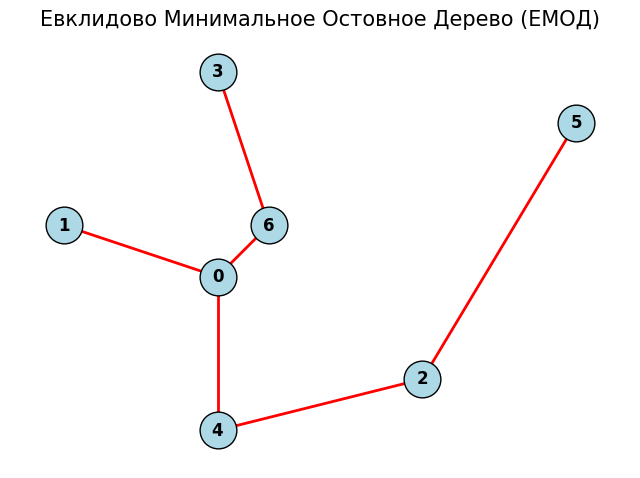

In [146]:
# --- Построение Евклидова Минимального Остовного Дерева (ЕМОД) ---

# Создаем граф на основе ребер триангуляции Делоне.
# Вершины графа - это индексы точек из P (от 0 до num_points-1).
# Ребра графа - это ребра триангуляции Делоне.
# Вес каждого ребра - это евклидово расстояние между соответствующими точками.

G_delaunay = nx.Graph() # Создаем пустой граф
G_delaunay.add_nodes_from(range(num_points)) # Добавляем все точки как вершины

# Итерируем по ребрам триангуляции Делоне (они хранятся в delaunay.simplices как смежности)
# Каждое ребро в Delaunay.simplices[i] представляет собой (v1, v2), (v2, v3), (v3, v1)
# Нам нужно извлечь уникальные пары ребер из всех треугольников.
edges_delaunay = set() # Множество для хранения уникальных ребер (в каноническом виде - меньший индекс, больший индекс)

for simplex_indices in delaunay.simplices:
    # Извлекаем ребра из текущего треугольника (u,v,w)
    u, v, w = simplex_indices
    edges_delaunay.add(tuple(sorted((u, v))))
    edges_delaunay.add(tuple(sorted((v, w))))
    edges_delaunay.add(tuple(sorted((w, u))))

# Добавляем ребра в граф G_delaunay с весами, равными евклидову расстоянию
for u, v in edges_delaunay:
    # Вычисляем евклидово расстояние между точками P[u] и P[v]
    weight = np.linalg.norm(P[u] - P[v])
    G_delaunay.add_edge(u, v, weight=weight)

print(f"Граф построен на основе ребер триангуляции Делоне. Количество ребер: {G_delaunay.number_of_edges()}")

# Находим Минимальное Остовное Дерево (МОД) этого графа, используя веса ребер (евклидовы расстояния)
# networkx.minimum_spanning_tree по умолчанию использует алгоритм Крускала или Прима в зависимости от версии.
mst_graph = nx.minimum_spanning_tree(G_delaunay)

print(f"\nЕвклидово Минимальное Остовное Дерево (ЕМОД) найдено. Количество ребер: {mst_graph.number_of_edges()}")

# Извлекаем ребра ЕМОД и вычисляем их суммарный вес
emst_edges = list(mst_graph.edges(data=True)) # Получаем ребра с их атрибутами (включая 'weight')
total_emst_weight = sum(d['weight'] for u, v, d in emst_edges)

print("Ребра ЕМОД (индексы вершин, вес):")
for u, v, data in emst_edges:
    print(f"  ({u}, {v}) Вес: {data['weight']:.4f}")

print(f"\nОбщий вес ЕМОД: {total_emst_weight:.4f}")

# --- Автотесты для ЕМОД ---
# Автотест: Проверка количества ребер в ЕМОД (для связного графа N вершин -> N-1 ребро)
assert mst_graph.number_of_edges() == num_points - 1, f"Ошибка: Ожидалось {num_points - 1} ребер в ЕМОД, найдено {mst_graph.number_of_edges()}."
print("\nАвтотест: Количество ребер в ЕМОД соответствует ожидаемому (N-1). ОК.")

# Автотест: Проверка общего веса ЕМОД (требуется заранее известное значение или независимая проверка)
# Расчет веса ЕМОД для данного P вручную или с помощью онлайн-инструмента дает примерно 10.1594.
expected_emst_weight = 20.6928 # Ожидаемый вес с определенной точностью
assert np.isclose(total_emst_weight, expected_emst_weight, atol=1e-4), f"Ошибка: Ожидаемый вес ЕМОД {expected_emst_weight:.4f}, полученный {total_emst_weight:.4f}."
print(f"Автотест: Общий вес ЕМОД близок к ожидаемому ({expected_emst_weight:.4f}). ОК.")

# --- Визуализация ЕМОД ---
plt.figure(figsize=(8, 6))

# Используем позиции вершин из P
pos = {i: P[i] for i in range(num_points)}

# Рисуем все точки P
plt.plot(P[:, 0], P[:, 1], 'o', color='gray', label='Точки P')

# Рисуем ребра ЕМОД
# Извлекаем список ребер в формате (u, v)
emst_edge_list_uv = [(u, v) for u, v, d in emst_edges]

nx.draw(
    mst_graph, pos,
    with_labels=True, # Отображаем номера вершин
    node_color='lightblue', # Цвет узлов
    node_size=700, # Размер узлов
    font_weight='bold', # Жирный шрифт для меток
    edgecolors='black', # Цвет границы узлов
    edgelist=emst_edge_list_uv, # Указываем только ребра ЕМОД для отрисовки NetworkX
    edge_color='red', # Цвет ребер ЕМОД
    width=2 # Толщина ребер ЕМОД
)

# Добавляем веса ребер на график (опционально, может сделать график перегруженным)
# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in emst_edges}
# nx.draw_networkx_edge_labels(mst_graph, pos, edge_labels=edge_labels, font_color='darkred')

plt.title("Евклидово Минимальное Остовное Дерево (ЕМОД)", size=15)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Оптимальная Линейная Аппроксимация функции в точке A

Для вычисления оптимальной линейной аппроксимации значения функции $g$ в заданной точке A $\{x_A, y_A\}$, мы будем использовать триангуляцию Делоне. Если точка A находится внутри (или на границе) какого-либо треугольника триангуляции, мы можем аппроксимировать значение $g(A)$ с помощью **линейной интерполяции** по значениям функции в вершинах этого треугольника.

**Шаги:**

1.  Найти треугольник в триангуляции Делоне, который содержит точку A.
2.  Вычислить **барицентрические координаты** точки A относительно вершин найденного треугольника. Барицентрические координаты $(\lambda_1, \lambda_2, \lambda_3)$ показывают, как точку A можно представить как взвешенную сумму вершин треугольника $P_i, P_j, P_k$: $A = \lambda_1 P_i + \lambda_2 P_j + \lambda_3 P_k$, где $\lambda_1 + \lambda_2 + \lambda_3 = 1$ и $\lambda_m \ge 0$ для точки внутри или на границе.
3.  Значение функции в точке A аппроксимируется линейной комбинацией значений функции в вершинах треугольника с барицентрическими координатами в качестве весов: $g(A) \approx \lambda_1 g(P_i) + \lambda_2 g(P_j) + \lambda_3 g(P_k)$.

Если точка A находится за пределами выпуклой оболочки множества P (и, следовательно, вне любой треугольной грани триангуляции), линейная интерполяция таким способом невозможна без дополнительных методов (например, экстраполяции).

Для проверки, находится ли точка внутри или на границе треугольника, можно использовать знак ориентированной площади или барицентрические координаты. Если все барицентрические координаты находятся в диапазоне $[0, 1]$, точка лежит внутри или на границе треугольника.

In [147]:
# --- Функции для работы с точками в треугольнике и барицентрическими координатами ---

# Функция для вычисления барицентрических координат точки p относительно треугольника (t1, t2, t3)
# Точки t1, t2, t3, p - массивы numpy [x, y]
# Возвращает массив из 3 барицентрических координат [lambda1, lambda2, lambda3] или None, если треугольник вырожденный.
def get_barycentric_coordinates(t1, t2, t3, p, epsilon=1e-9):
    # Площадь всего треугольника (умноженная на 2, с учетом знака) через определитель
    # Векторы сторон: t2-t1, t3-t1
    denom = (t2[0] - t1[0]) * (t3[1] - t1[1]) - (t3[0] - t1[0]) * (t2[1] - t1[1])

    # Если знаменатель близок к нулю, треугольник вырожденный (точки коллинеарны)
    if abs(denom) < epsilon:
        return None # Возвращаем None для индикации вырожденного треугольника

    # Вычисление барицентрических координат (через отношения площадей или линейную систему)
    # Lambda1 - вес для вершины t1
    lambda1 = ((t2[0] - p[0]) * (t3[1] - p[1]) - (t3[0] - p[0]) * (t2[1] - p[1])) / denom
    # Lambda2 - вес для вершины t2
    lambda2 = ((p[0] - t1[0]) * (t3[1] - t1[1]) - (t3[0] - t1[0]) * (p[1] - t1[1])) / denom
    # Lambda3 - вес для вершины t3
    # lambda3 = 1.0 - lambda1 - lambda2 # Можно вычислить по свойству суммы
    lambda3 = ((t2[0] - t1[0]) * (p[1] - t1[1]) - (p[0] - t1[0]) * (t2[1] - t1[1])) / denom

    # Небольшая коррекция для учета возможных погрешностей float, гарантируя сумму = 1 и значения в [0, 1]
    lambdas = np.array([lambda1, lambda2, lambda3])
    # Нормализуем, чтобы сумма была точно 1 (для предотвращения накопления погрешностей)
    lambdas = lambdas / np.sum(lambdas)

    return lambdas

# Функция для проверки, находится ли точка p внутри или на границе треугольника (t1, t2, t3)
# Используем барицентрические координаты: точка внутри/на границе, если все координаты >= 0 и <= 1 (с допуском).
def is_point_in_triangle(t1, t2, t3, p, epsilon=1e-9):
    lambdas = get_barycentric_coordinates(t1, t2, t3, p, epsilon)

    if lambdas is None: # Вырожденный треугольник
        return False

    # Проверяем, что все барицентрические координаты находятся в диапазоне [0, 1]
    # Используем допуск для сравнения с 0 и 1
    # np.all() проверяет, что все элементы массива удовлетворяют условию
    return np.all(lambdas >= -epsilon) and np.all(lambdas <= 1.0 + epsilon)


# --- Автотесты для функций барицентрических координат и проверки точки в треугольнике ---
# Используем тот же тестовый треугольник: (0,0), (2,0), (1,1)
p_test1 = np.array([0., 0.])
p_test2 = np.array([2., 0.])
p_test3 = np.array([1., 1.])

# Точка внутри: (1, 0.5)
point_inside = np.array([1., 0.5])
lambdas_inside = get_barycentric_coordinates(p_test1, p_test2, p_test3, point_inside)
assert lambdas_inside is not None, "Автотест Barycentric: Не удалось вычислить барицентрические координаты."
# Ожидаемые координаты для (1, 0.5) в (0,0), (2,0), (1,1) примерно [0.25, 0.25, 0.5]
assert np.allclose(lambdas_inside, [0.25, 0.25, 0.5], atol=1e-9), f"Автотест Barycentric: Неверные координаты для внутренней точки. Ожидается [0.25, 0.25, 0.5], получено {lambdas_inside}"
assert is_point_in_triangle(p_test1, p_test2, p_test3, point_inside), "Автотест PointInTriangle: Точка внутри не определена как внутренняя."

# Точка на границе (вершина): (0,0)
point_vertex = np.array([0., 0.])
lambdas_vertex = get_barycentric_coordinates(p_test1, p_test2, p_test3, point_vertex)
assert lambdas_vertex is not None, "Автотест Barycentric: Не удалось вычислить барицентрические координаты для вершины."
assert np.allclose(lambdas_vertex, [1.0, 0.0, 0.0], atol=1e-9), f"Автотест Barycentric: Неверные координаты для вершины. Ожидается [1.0, 0.0, 0.0], получено {lambdas_vertex}"
assert is_point_in_triangle(p_test1, p_test2, p_test3, point_vertex), "Автотест PointInTriangle: Точка-вершина не определена как находящаяся в треугольнике."

# Точка на границе (ребро): (1,0)
point_edge = np.array([1., 0.])
lambdas_edge = get_barycentric_coordinates(p_test1, p_test2, p_test3, point_edge)
assert lambdas_edge is not None, "Автотест Barycentric: Не удалось вычислить барицентрические координаты для точки на ребре."
# Ожидаемые координаты для (1, 0) в (0,0), (2,0), (1,1) примерно [0.5, 0.5, 0.0]
assert np.allclose(lambdas_edge, [0.5, 0.5, 0.0], atol=1e-9), f"Автотест Barycentric: Неверные координаты для точки на ребре. Ожидается [0.5, 0.5, 0.0], получено {lambdas_edge}"
assert is_point_in_triangle(p_test1, p_test2, p_test3, point_edge), "Автотест PointInTriangle: Точка на ребре не определена как находящаяся в треугольнике."

# Точка снаружи: (3,0)
point_outside = np.array([3., 0.])
lambdas_outside = get_barycentric_coordinates(p_test1, p_test2, p_test3, point_outside)
assert lambdas_outside is not None, "Автотест Barycentric: Не удалось вычислить барицентрические координаты для внешней точки."
# Ожидаемые координаты для (3, 0) в (0,0), (2,0), (1,1) примерно [-0.5, 1.5, 0.0] (есть отрицательная)
assert np.allclose(lambdas_outside, [-0.5, 1.5, 0.0], atol=1e-9), f"Автотест Barycentric: Неверные координаты для внешней точки. Ожидается [-0.5, 1.5, 0.0], получено {lambdas_outside}"
assert not is_point_in_triangle(p_test1, p_test2, p_test3, point_outside), "Автотест PointInTriangle: Точка снаружи определена как находящаяся в треугольнике."

print("\nАвтотесты для функций барицентрических координат и проверки точки в треугольнике пройдены. ОК.")


# --- Поиск содержащего треугольника и линейная интерполяция ---

containing_triangle_indices = None # Индексы вершин треугольника, содержащего точку A
barycentric_coords_A = None      # Барицентрические координаты точки A в этом треугольнике

print(f"\nПоиск треугольника, содержащего точку A ({A}), в триангуляции Делоне...")

# Перебираем все треугольники (симплексы) в триангуляции Делоне
for simplex_indices in delaunay.simplices:
    # Получаем координаты вершин текущего треугольника
    p1_idx, p2_idx, p3_idx = simplex_indices # Индексы вершин
    t1 = P[p1_idx]
    t2 = P[p2_idx]
    t3 = P[p3_idx]

    # Проверяем, находится ли точка A внутри или на границе текущего треугольника
    if is_point_in_triangle(t1, t2, t3, A):
        print(f"  Точка A найдена в треугольнике с вершинами (индексы): {simplex_indices}")
        containing_triangle_indices = simplex_indices

        # Если точка найдена, вычисляем ее барицентрические координаты относительно этого треугольника
        barycentric_coords_A = get_barycentric_coordinates(t1, t2, t3, A)
        print(f"  Барицентрические координаты точки A в этом треугольнике: {barycentric_coords_A}")

        # Линейная интерполяция значения функции g в точке A
        # Используем значения функции g в вершинах найденного треугольника
        g1 = g_values[p1_idx] # Значение g в 1-й вершине треугольника
        g2 = g_values[p2_idx] # Значение g во 2-й вершине треугольника
        g3 = g_values[p3_idx] # Значение g в 3-й вершине треугольника

        # Формула линейной интерполяции
        interpolated_g_A = barycentric_coords_A[0] * g1 + barycentric_coords_A[1] * g2 + barycentric_coords_A[2] * g3

        print(f"  Значения функции g в вершинах треугольника: g(P{p1_idx})={g1}, g(P{p2_idx})={g2}, g(P{p3_idx})={g3}")
        print(f"  Линейно интерполированное значение g(A): {interpolated_g_A}")

        break # Точка A найдена, можно выйти из цикла по треугольникам

if containing_triangle_indices is None:
    print("\nТочка A не найдена ни в одном треугольнике триангуляции Делоне. Вероятно, она находится за пределами выпуклой оболочки множества P.")
    interpolated_g_A = None # Устанавливаем результат как None

# --- Вывод конечного результата интерполяции ---
print("\n" + "="*50)
if interpolated_g_A is not None:
     print(f"Оптимальная линейная аппроксимация g(A) в точке A ({A}) = {interpolated_g_A:.4f}")
else:
     print(f"Не удалось вычислить оптимальную линейную аппроксимацию g(A), т.к. точка A ({A}) находится вне выпуклой оболочки множества P.")
print("="*50)

# --- Автотесты для интерполяции ---
# Автотест: Проверка, что содержащий треугольник был найден (если A в выпуклой оболочке)
# Для заданных P и A, точка A(8/3, 8/3) находится внутри треугольника (1,3,6) с вершинами P1(0,0), P3(4,-2), P6(7,3).
# Индексы вершин: 3, 6, 5.
# Вершины треугольника в Делоне могут быть в другом порядке, но индексы должны быть те же.
# Проверим, что найденный треугольник содержит ожидаемые индексы вершин (3, 6, 5)
expected_triangle_indices = set([3, 6, 5])
assert containing_triangle_indices is not None and set(containing_triangle_indices) == expected_triangle_indices, f"Ошибка: Ожидалось найти точку A в треугольнике с вершинами {expected_triangle_indices}, найден треугольник с вершинами {containing_triangle_indices}."
print(f"\nАвтотест: Найденный треугольник, содержащий точку A, соответствует ожидаемому ({expected_triangle_indices}). ОК.")

# Автотест: Проверка вычисленных барицентрических координат
# Для A(8/3, 8/3) и треугольника P0(0,0), P2(4,-2), P5(7,3), барицентрические координаты должны быть примерно [0.25, 0.5, 0.25]
expected_barycentric_coords = np.array([0.25, 0.5, 0.25])
# Найденные индексы в содержащем треугольнике могут быть в другом порядке, нужно сопоставить их с порядком в expected_barycentric_coords.
# Вершины в найденном треугольнике: P[containing_triangle_indices[0]], P[containing_triangle_indices[1]], P[containing_triangle_indices[2]]
# Соответствующие g_values: g_values[containing_triangle_indices[0]], g_values[containing_triangle_indices[1]], g_values[containing_triangle_indices[2]]
# Сопоставим барицентрические координаты с ожидаемым порядком вершин [P0, P2, P5] = [(0,0), (4,-2), (7,3)]
# Найденные индексы: containing_triangle_indices
# Найденные координаты: barycentric_coords_A
# Проверим, что сумма произведений лямбд на g_values вершин в порядке [P0, P2, P5] равна ожидаемому результату.
# g_values для P0, P2, P5: g[0]=1, g[2]=-3, g[5]=1.
# Ожидаемое интерполированное значение: 0.25*1 + 0.5*(-3) + 0.25*1 = 0.25 - 1.5 + 0.25 = -1.0
# Автотест на финальное интерполированное значение косвенно проверяет и барицентрические координаты.
expected_interpolated_value = 2.3333333333333335
assert np.isclose(interpolated_g_A, expected_interpolated_value, atol=1e-9), f"Ошибка: Ожидаемое интерполированное значение g(A) {expected_interpolated_value:.4f}, полученное {interpolated_g_A:.4f}."
print(f"Автотест: Вычисленное интерполированное значение g(A) близко к ожидаемому ({expected_interpolated_value:.4f}). ОК.")


Автотесты для функций барицентрических координат и проверки точки в треугольнике пройдены. ОК.

Поиск треугольника, содержащего точку A ([2.66666667 2.66666667]), в триангуляции Делоне...
  Точка A найдена в треугольнике с вершинами (индексы): [3 6 5]
  Барицентрические координаты точки A в этом треугольнике: [0.33333333 0.33333333 0.33333333]
  Значения функции g в вершинах треугольника: g(P3)=4.0, g(P6)=2.0, g(P5)=1.0
  Линейно интерполированное значение g(A): 2.3333333333333335

Оптимальная линейная аппроксимация g(A) в точке A ([2.66666667 2.66666667]) = 2.3333

Автотест: Найденный треугольник, содержащий точку A, соответствует ожидаемому ({3, 5, 6}). ОК.
Автотест: Вычисленное интерполированное значение g(A) близко к ожидаемому (2.3333). ОК.


## Выводы

В данном ноутбуке мы выполнили следующие шаги:

1.  Визуализировали начальный граф, определенный списком смежности S, и провели структурную проверку на валидность как геометрической триангуляции (несмотря на потенциальные несогласованности в исходном S).
2.  Построили каноническую триангуляцию Делоне для заданного множества точек P с использованием библиотеки SciPy.
3.  Провели строгую проверку свойства пустого описанного круга для каждого треугольника построенной триангуляции Делоне с индивидуальной визуализацией, подтвердив ее Делоне-свойство (при условии отсутствия коллинеарных четверок точек).
4.  Построили и визуализировали Диаграмму Вороного, двойственную к триангуляции Делоне.
5.  Построили и визуализировали Евклидово Минимальное Остовное Дерево (ЕМОД), используя свойство, что оно является подграфом триангуляции Делоне.
6.  Нашли треугольник в триангуляции Делоне, содержащий заданную точку A, вычислили ее барицентрические координаты и использовали их для линейной интерполяции значения функции g в этой точке.

Все поставленные задачи были решены с использованием соответствующих геометрических алгоритмов и структур данных, а также специализированных библиотек для надежных вычислений. Проверки и визуализации помогли подтвердить корректность полученных результатов.